# Machine Learning applied to MuJoCo environment - Trigonometric models

* ### Author: Mowibox (Ousmane THIONGANE)
* ### Date: November 4th, 2024

## Imports

In [ ]:
import os
import time
import pandas as pd
from utils import displayLearningCurve
from tensorflow.keras.losses import MSE
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, save_model

## I - Context 

The main goal of this project is to create a Machine Learning model and train it to learn Forward Kinematics (by configuring an input value for the position and orientation of the end effector of a robotic arm, we return the values of the joints that enable this point to be reached).

## II - Datasets generation & prepraration

In this part, we will prepare the data to perform a regression the by generatinig the datasets.

### 1) 2D with 2 joints

Firstly, we record a sequence with by launching the script with the command line: `python3 run.py -env r2 -seed 2184503 -steps 100000 --log > 2R_2184503_100.csv`. This allows us to save the data in a csv and display it with pandas

The filename format is "\<model>\_\<seed>\_\<nr. of samples>.csv". Here 2R is the 2D with 2 joints model, 2184503 for the random seed n°2184503 and 100 for 100k steps:

In [35]:
filepath_2R = r'data/2R_2184503_100.csv'
df_2R = pd.read_csv(filepath_2R, sep=";", header=0).copy()

display(df_2R.head(5))
df_2R.info()

,j0,j1,cos(j0),cos(j1),sin(j0),sin(j1),ee_x,ee_y,ee_qw,ee_qz
0,0.034,0.003,0.999,1.000,0.034,0.003,0.210,0.007,1.000,0.018
1,0.048,0.004,0.999,1.000,0.048,0.004,0.210,0.010,1.000,0.026
2,0.073,0.038,0.997,0.999,0.073,0.038,0.209,0.020,0.998,0.056
3,0.093,0.098,0.996,0.995,0.093,0.098,0.208,0.030,0.995,0.096
4,0.136,0.153,0.991,0.988,0.135,0.152,0.205,0.045,0.990,0.144


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    cos(j0)  100000 non-null  float64
 3    cos(j1)  100000 non-null  float64
 4    sin(j0)  100000 non-null  float64
 5    sin(j1)  100000 non-null  float64
 6    ee_x     100000 non-null  float64
 7    ee_y     100000 non-null  float64
 8    ee_qw    100000 non-null  float64
 9    ee_qz    100000 non-null  float64
dtypes: float64(10)
memory usage: 7.6 MB


The .csv contains many informations about the simulation such as:
- The joints angles $j_0$, $j_1$
- The sine and the cosine of the joints angles: $\cos(j_0)$, $\sin(j_0)$, $\cos(j_1)$, $\sin(j_1)$
- The end-effector pose: $(x,y) = (ee_x, ee_y)$
- The end-effector orientation, based on quaternions: $q = (w,z) = (\cos(\frac{\theta_z}{2}), \sin(\frac{\theta_z}{2})) = ((ee_{qw})$, $(ee_{qz}))$ 



#### 1.a) Joint angles

In [36]:
X_2R = df_2R[[' cos(j0)', ' sin(j0)', ' cos(j1)', ' sin(j1)']].values

X_2R = pd.DataFrame(X_2R, columns=['cos(j0)', 'sin(j0)', 'cos(j1)', 'sin(j1)'])
display(X_2R.head(5))

,cos(j0),sin(j0),cos(j1),sin(j1)
0,0.999,0.034,1.000,0.003
1,0.999,0.048,1.000,0.004
2,0.997,0.073,0.999,0.038
3,0.996,0.093,0.995,0.098
4,0.991,0.135,0.988,0.152


#### 1.b) Fingertip position

In [37]:
y_2R_pos = df_2R[[' ee_x', ' ee_y']].values

#### 1.c) Fingertip orientation

In [38]:
y_2R_ori = df_2R[[' ee_qw', ' ee_qz']].values

Here, I choose to merge the end-effector position and orientation in one dataframe, so I can also try later what will happened when all the outputs are provided to the model. 

In [39]:
y_2R = pd.concat([pd.DataFrame(y_2R_pos, columns=['ee_x', 'ee_y']), 
                         pd.DataFrame(y_2R_ori, columns=['ee_qw', 'ee_qz'])], axis=1)

display(y_2R.head(5))

,ee_x,ee_y,ee_qw,ee_qz
0,0.210,0.007,1.000,0.018
1,0.210,0.010,1.000,0.026
2,0.209,0.020,0.998,0.056
3,0.208,0.030,0.995,0.096
4,0.205,0.045,0.990,0.144


### 2) 2D with 3 joints 

The 3R robot .csv contains the following informations:
- The joints angles $j_0$, $j_1$, $j_2$ 
- The sine and the cosine of the joints angles: $\cos(j_0)$, $\sin(j_0)$, $\cos(j_1)$, $\sin(j_1)$, $\cos(j_2)$, $\sin(j_2)$
- The end-effector pose: $(x,y) = (ee_x, ee_y)$
- The end-effector orientation, based on quaternions: $q = (w,z) = (\cos(\frac{\theta_z}{2}), \sin(\frac{\theta_z}{2})) = ((ee_{qw})$, $(ee_{qz}))$ 


In [40]:
filepath_3R = r'data/3R_2184503_100.csv'
df_3R = pd.read_csv(filepath_3R, sep=";", header=0).copy()

display(df_3R.head(3))
df_3R.info()

,j0,j1,j2,cos(j0),cos(j1),cos(j2),sin(j0),sin(j1),sin(j2),ee_x,ee_y,ee_qw,ee_qz
0,0.034,0.003,-0.002,0.999,1.0,1.0,0.034,0.003,-0.002,0.310,0.011,1.000,0.017
1,0.047,0.004,-0.003,0.999,1.0,1.0,0.047,0.004,-0.003,0.310,0.015,1.000,0.024
2,0.105,0.001,-0.008,0.994,1.0,1.0,0.105,0.001,-0.008,0.308,0.032,0.999,0.049


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    j2       100000 non-null  float64
 3    cos(j0)  100000 non-null  float64
 4    cos(j1)  100000 non-null  float64
 5    cos(j2)  100000 non-null  float64
 6    sin(j0)  100000 non-null  float64
 7    sin(j1)  100000 non-null  float64
 8    sin(j2)  100000 non-null  float64
 9    ee_x     100000 non-null  float64
 10   ee_y     100000 non-null  float64
 11   ee_qw    100000 non-null  float64
 12   ee_qz    100000 non-null  float64
dtypes: float64(13)
memory usage: 9.9 MB


The processing of the data is basically the same as on the previous part:

#### 2.a) Joint angles

In [41]:
X_3R = df_3R[[' cos(j0)', ' sin(j0)', ' cos(j1)', ' sin(j1)', ' cos(j2)', ' sin(j2)']].values
X_3R = pd.DataFrame(X_3R, columns=['cos(j0)', 'sin(j0)', 'cos(j1)', 'sin(j1)', 'cos(j2)', 'sin(j2)'])
display(X_3R.head(3))

,cos(j0),sin(j0),cos(j1),sin(j1),cos(j2),sin(j2)
0,0.999,0.034,1.0,0.003,1.0,-0.002
1,0.999,0.047,1.0,0.004,1.0,-0.003
2,0.994,0.105,1.0,0.001,1.0,-0.008


#### 2.b) Fingertip position

In [42]:
y_3R_pos = df_3R[[' ee_x', ' ee_y']].values

#### 2.c) Fingertip orientation

In [43]:
y_3R_ori = df_3R[[' ee_qw', ' ee_qz']].values

In [44]:
y_3R = pd.concat([pd.DataFrame(y_3R_pos, columns=['ee_x', 'ee_y']), 
                         pd.DataFrame(y_3R_ori, columns=['ee_qw', 'ee_qz'])], axis=1)

display(y_3R.head(3))

,ee_x,ee_y,ee_qw,ee_qz
0,0.310,0.011,1.000,0.017
1,0.310,0.015,1.000,0.024
2,0.308,0.032,0.999,0.049


### 3) 3D with 5 joints

Since the 5R robot .csv is a 3D-case, the end-effector pose will contain more components:
- The joints angles $j_0$, $j_1$, $j_2$, $j_3$, $j_4$ 
- The sine and the cosine of the joints angles: $\cos(j_0)$, $\sin(j_0)$, $\cos(j_1)$, $\sin(j_1)$, $\cos(j_2)$, $\sin(j_2)$, $\cos(j_3)$, $\sin(j_3)$, $\cos(j_4)$, $\sin(j_4)$
- The end-effector pose: $(x,y,z) = (ee_x, ee_y, ee_z)$
- The end-effector orientation, based on quaternions: $q = (w,x,y,z) = (\cos(\frac{\theta}{2}), \sin(\frac{\theta}{2}), \sin(\frac{\theta}{2}), \sin(\frac{\theta}{2})) = ((ee_{qw}), (ee_{qx}), (ee_{qy}), (ee_{qz}))$ 


In [45]:
filepath_5R = r'data/5R_2184503_100.csv'
df_5R = pd.read_csv(filepath_5R, sep=";", header=0).copy()

display(df_5R.head(3))
df_5R.info()

,j0,j1,j2,j3,j4,cos(j0),cos(j1),cos(j2),cos(j3),cos(j4),...,sin(j2),sin(j3),sin(j4),ee_x,ee_y,ee_z,ee_qw,ee_qx,ee_qy,ee_qz
0,0.000,0.000,0.000,0.000,0.000,1.000,1.0,1.0,1.000,1.0,...,0.000,0.000,0.000,0.000,0.000,0.590,1.000,0.000,0.000,0.000
1,0.014,0.001,-0.001,0.031,-0.005,1.000,1.0,1.0,1.000,1.0,...,-0.001,0.031,-0.005,0.007,0.001,0.590,1.000,-0.003,0.016,0.007
2,0.037,0.031,-0.005,0.096,-0.011,0.999,1.0,1.0,0.995,1.0,...,-0.005,0.096,-0.011,0.035,0.003,0.588,0.998,-0.007,0.061,0.019


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    j2       100000 non-null  float64
 3    j3       100000 non-null  float64
 4    j4       100000 non-null  float64
 5    cos(j0)  100000 non-null  float64
 6    cos(j1)  100000 non-null  float64
 7    cos(j2)  100000 non-null  float64
 8    cos(j3)  100000 non-null  float64
 9    cos(j4)  100000 non-null  float64
 10   sin(j0)  100000 non-null  float64
 11   sin(j1)  100000 non-null  float64
 12   sin(j2)  100000 non-null  float64
 13   sin(j3)  100000 non-null  float64
 14   sin(j4)  100000 non-null  float64
 15   ee_x     100000 non-null  float64
 16   ee_y     100000 non-null  float64
 17   ee_z     100000 non-null  float64
 18   ee_qw    100000 non-null  float64
 19   ee_qx    100000 non-null  float64
 20   ee_q

#### 3.a) Joint angles 

In [46]:
X_5R = df_5R[[' cos(j0)', ' sin(j0)', ' cos(j1)', ' sin(j1)', ' cos(j2)', ' sin(j2)', ' cos(j3)', ' sin(j3)', ' cos(j4)', ' sin(j4)']].values

X_5R = pd.DataFrame(X_5R, columns=['cos(j0)', 'sin(j0)', 'cos(j1)', 'sin(j1)', 'cos(j2)', 'sin(j2)', 'cos(j3)', 'sin(j3)', 'cos(j4)', 'sin(j4)'])
display(X_5R.head(5))

,cos(j0),sin(j0),cos(j1),sin(j1),cos(j2),sin(j2),cos(j3),sin(j3),cos(j4),sin(j4)
0,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.0,0.000
1,1.000,0.014,1.000,0.001,1.000,-0.001,1.000,0.031,1.0,-0.005
2,0.999,0.037,1.000,0.031,1.000,-0.005,0.995,0.096,1.0,-0.011
3,0.999,0.034,0.998,0.067,0.999,-0.049,0.989,0.146,1.0,0.014
4,0.999,0.036,0.997,0.074,0.988,-0.156,0.987,0.160,1.0,0.030


#### 3.b) Fingertip position

In [47]:
y_5R_pos = df_5R[[' ee_x', ' ee_y', ' ee_z']].values

#### 3.c) Fingertip orientation

In [48]:
y_5R_ori = df_5R[[' ee_qw', ' ee_qx', ' ee_qy', ' ee_qz']].values

In [49]:
y_5R = pd.concat([pd.DataFrame(y_5R_pos, columns=['ee_x', 'ee_y', "ee_z"]), 
                         pd.DataFrame(y_5R_ori, columns=['ee_qw', 'ee_qx', 'ee_qy', 'ee_qz'])], axis=1)

display(y_5R.head(5))

,ee_x,ee_y,ee_z,ee_qw,ee_qx,ee_qy,ee_qz
0,0.000,0.000,0.590,1.000,0.000,0.000,0.000
1,0.007,0.001,0.590,1.000,-0.003,0.016,0.007
2,0.035,0.003,0.588,0.998,-0.007,0.061,0.019
3,0.048,-0.000,0.587,0.996,0.006,0.082,0.016
4,0.017,-0.003,0.589,0.999,0.014,0.039,0.017


## III - Learning Forward Kinematics

### 1) 2D with 2 joints

We are dividing the dataset to randomly take 80% of the data for training the model, and 20% for testing. Let's try first by giving only the position:

In [50]:
X_2R_train, X_2R_test, y_2R_train, y_2R_test = train_test_split(X_2R, y_2R_pos, test_size=0.2, random_state=2184503)
print(X_2R_train.shape, y_2R_train.shape)
print(y_2R_test.shape, y_2R_test.shape)

(80000, 4) (80000, 2)
(20000, 2) (20000, 2)


For a more challenging task, we can train our model by taking a subset of the main dataset e.g. e are only taking a certain percentage of samples from the whole dataset:

In [51]:
percentage_2R = 0.1 # Relative percentage 

subset_size_train = int(len(X_2R_train)*percentage_2R)
subset_size_test = int(len(X_2R_test)*percentage_2R)

X_2R_train = X_2R_train[:subset_size_train]
y_2R_train = y_2R_train[:subset_size_train]
X_2R_test = X_2R_test[:subset_size_test]
y_2R_test = y_2R_test[:subset_size_test]

print(X_2R_train.shape, y_2R_train.shape)
print(y_2R_test.shape, y_2R_test.shape)

(8000, 4) (8000, 2)
(2000, 2) (2000, 2)


##### Model definition 

To define our model, we start by creating a simple neural network with a few hidden layers and ReLU as the activation function. The output layer contains a linear activation function. We will then adjust the hyperparameters after some tests.

In [52]:
model_2R = Sequential()
model_2R.add(Input((X_2R_train.shape[1],)))
model_2R.add(Dense(80, activation="relu"))
model_2R.add(Dense(42, activation="relu"))
model_2R.add(Dense(y_2R_train.shape[1], activation="linear"))

model_2R.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 80)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 42)             │         3,402 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            86 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,888 (15.19 KB)

 Trainable params: 3,888 (15.19 KB)

 Non-trainable params: 0 (0.00 B)

##### Loss function & optimizer

The MSE is commonly used as a loss function in a regression problem, especially in our case where we have no outliers that would impair model performance. 

That's why I've chosen to input only the cosines and sines of the joints, because by directly use the angle values of the joints, the problem is that values can be close but still have a large square error. 

For example, $0$ and $2\pi$ are values which are very close together on the trigonometric circle, but this will result on a large error in terms of squared diffrence.

In [53]:
model_2R.compile(loss=MSE, optimizer=Adam(learning_rate=0.001))

##### Solver - Training phase

We then train our model over a predefined number of epochs. At each iteration, the model's prediction is compared with the actual value and a gradient descent is applied with the aim of minimizing the MSE. The model weights are readjusted accordingly.

In [54]:
epochs_2R = 20

start = time.time()
history_2R = model_2R.fit(X_2R_train, y_2R_train,
                    epochs=epochs_2R,
                    validation_data=(X_2R_test, y_2R_test),
                    verbose=1)
training_time = time.time() - start


y_2R_train_pred = model_2R.predict(X_2R_train)
y_2R_test_pred = model_2R.predict(X_2R_test)

mae_2R_train = mean_absolute_error(y_2R_train, y_2R_train_pred)
mae_2R_test = mean_absolute_error(y_2R_test, y_2R_test_pred)

r2_2R_test = r2_score(y_2R_test, y_2R_test_pred)
r2_2R_train = r2_score(y_2R_train, y_2R_train_pred)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066 - val_loss: 6.5477e-05
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3716e-05 - val_loss: 2.9482e-05
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7469e-05 - val_loss: 1.9506e-05
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7524e-05 - val_loss: 1.4743e-05
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4147e-05 - val_loss: 1.2134e-05
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1986e-05 - val_loss: 1.0416e-05
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.5450e-06 - val_loss: 1.0175e-05
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3428e-06 - val_loss: 8.0558e-06
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.9512e-06 - val_loss: 1.0508e-05
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 8.0872e-06 - val_loss: 6.5366e-06
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss

##### Loss display on training and validation

I wrote a set of functions on the 'utils.py' that I'm going to use for models and computations utilities (see the file for more details). Here, the 'displayLearningCurve' function allows me to display the loss for training and validation.

I also computed some metrics to evaluate the performance of my models (Training time, Final Loss, Mean Absolute Error, R² score):

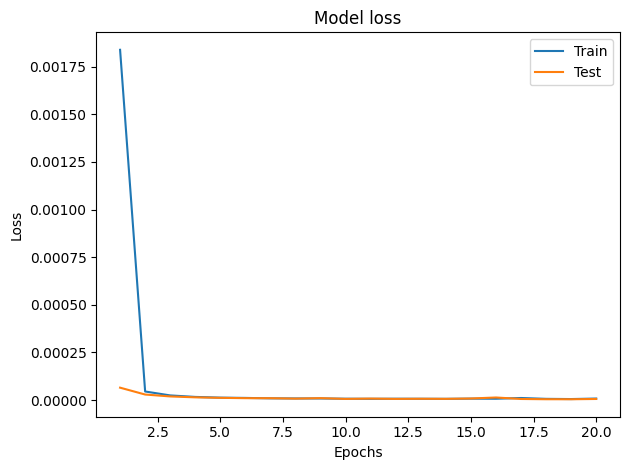

== Training Time ==
6.28 seconds

== Final loss ==
Train: 8.36861818243051e-06
Test: 6.17147134107654e-06

== Mean absolute error ==
Train: 0.001916212007260184
Test: 0.0019859093438037677

== R2 Score ==
Train: 0.9993473326532061
Test: 0.9993008523330325


In [55]:
displayLearningCurve(history=history_2R, 
                    epochs=epochs_2R)

print(f"== Training Time ==\n{training_time:.2f} seconds\n")
print(f"== Final loss ==\nTrain: {history_2R.history['loss'][-1]}\nTest: {history_2R.history['val_loss'][-1]}\n")
print(f"== Mean absolute error ==\nTrain: {mae_2R_train}\nTest: {mae_2R_test}\n")
print(f"== R2 Score ==\nTrain: {r2_2R_train}\nTest: {r2_2R_test}")

### 2) 2D with 3 joints

In [56]:
X_3R_train, X_3R_test, y_3R_train, y_3R_test = train_test_split(X_3R, y_3R_pos, test_size=0.2, random_state=2184503)
print(X_3R_train.shape, y_3R_train.shape)
print(y_3R_test.shape, y_3R_test.shape)

(80000, 6) (80000, 2)
(20000, 2) (20000, 2)


In [57]:
percentage_3R = 0.1

subset_size_train = int(len(X_3R_train)*percentage_3R)
subset_size_test = int(len(X_3R_test)*percentage_3R)

X_3R_train = X_3R_train[:subset_size_train]
y_3R_train = y_3R_train[:subset_size_train]
X_3R_test = X_3R_test[:subset_size_test]
y_3R_test = y_3R_test[:subset_size_test]

print(X_3R_train.shape, y_3R_train.shape)
print(y_3R_test.shape, y_3R_test.shape)

(8000, 6) (8000, 2)
(2000, 2) (2000, 2)


In [58]:
model_3R = Sequential()
model_3R.add(Input((X_3R_train.shape[1],)))
model_3R.add(Dense(128, activation="relu"))
model_3R.add(Dense(32, activation="relu"))
model_3R.add(Dense(8, activation="relu"))
model_3R.add(Dense(y_3R_train.shape[1], activation="linear"))
model_3R.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,306 (20.73 KB)

 Trainable params: 5,306 (20.73 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model_3R.compile(loss=MSE, optimizer=Adam(learning_rate=0.001))

epochs_3R = 20
start = time.time()
history_3R = model_3R.fit(X_3R_train, y_3R_train,
                    epochs=epochs_3R,
                    validation_data=(X_3R_test, y_3R_test),
                    verbose=1)
training_time = time.time() - start


y_3R_train_pred = model_3R.predict(X_3R_train)
y_3R_test_pred = model_3R.predict(X_3R_test)

mae_3R_train = mean_absolute_error(y_3R_train, y_3R_train_pred)
mae_3R_test = mean_absolute_error(y_3R_test, y_3R_test_pred)

r2_3R_test = r2_score(y_3R_test, y_3R_test_pred)
r2_3R_train = r2_score(y_3R_train, y_3R_train_pred)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0085 - val_loss: 2.6292e-04
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 2.1027e-04 - val_loss: 1.2248e-04
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 1.1672e-04 - val_loss: 8.3340e-05
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 8.2012e-05 - val_loss: 7.6740e-05
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 6.8835e-05 - val_loss: 7.3621e-05
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 5.6835e-05 - val_loss: 5.5249e-05
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 5.5909e-05 - val_loss: 4.9629e-05
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 4.9384e-05 - val_loss: 4.6692e-05
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 4.6476e-05 - val_loss: 4.4787e-05
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 4.2002e-05 - val_loss: 3.8619e-05
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 

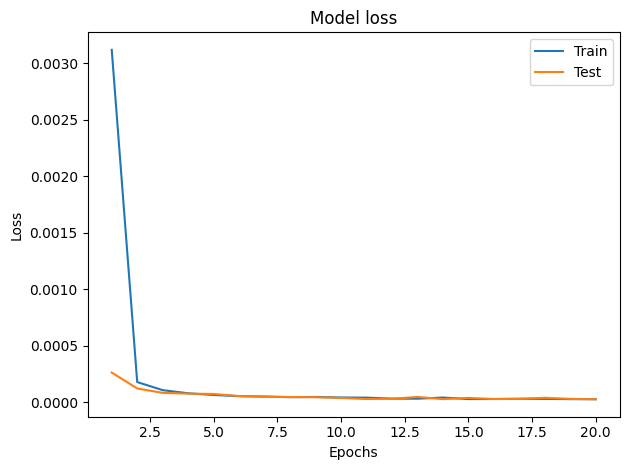

== Training Time ==
6.08 seconds

== Final loss ==
Train: 2.7354328267392702e-05
Test: 2.7032090656575747e-05

== Mean absolute error ==
Train: 0.003918442394704791
Test: 0.004133482844100337

== R2 Score ==
Train: 0.9990033193353802
Test: 0.9988761898130123


In [60]:
displayLearningCurve(history=history_3R, 
                    epochs=epochs_3R)

print(f"== Training Time ==\n{training_time:.2f} seconds\n")
print(f"== Final loss ==\nTrain: {history_3R.history['loss'][-1]}\nTest: {history_3R.history['val_loss'][-1]}\n")
print(f"== Mean absolute error ==\nTrain: {mae_3R_train}\nTest: {mae_3R_test}\n")
print(f"== R2 Score ==\nTrain: {r2_3R_train}\nTest: {r2_3R_test}")

### 3) 3D with 5 joints

In [61]:
X_5R_train, X_5R_test, y_5R_train, y_5R_test = train_test_split(X_5R, y_5R_pos, test_size=0.2, random_state=2184503)
print(X_5R_train.shape, y_5R_train.shape)
print(y_5R_test.shape, y_5R_test.shape)

(80000, 10) (80000, 3)
(20000, 3) (20000, 3)


Since the model's complexity is greater for the 5R robot arm (more parameters to take into account and an additional dimension), a larger percentage of the main dataset is used. 

In [62]:
percentage_5R = 0.8

subset_size_train = int(len(X_5R_train)*percentage_5R)
subset_size_test = int(len(X_5R_test)*percentage_5R)

X_5R_train = X_5R_train[:subset_size_train]
y_5R_train = y_5R_train[:subset_size_train]
X_5R_test = X_5R_test[:subset_size_test]
y_5R_test = y_5R_test[:subset_size_test]

print(X_5R_train.shape, y_5R_train.shape)
print(y_5R_test.shape, y_5R_test.shape)

(64000, 10) (64000, 3)
(16000, 3) (16000, 3)


In [63]:
model_5R = Sequential()
model_5R.add(Input((X_5R_train.shape[1],)))
model_5R.add(Dense(256, activation="relu"))
model_5R.add(Dense(64, activation="relu"))
model_5R.add(Dense(16, activation="relu"))
model_5R.add(Dense(4, activation="relu"))
model_5R.add(Dense(y_5R_train.shape[1], activation="linear"))
model_5R.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,387 (79.64 KB)

 Trainable params: 20,387 (79.64 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model_5R.compile(loss=MSE, optimizer=Adam(learning_rate=0.001))

epochs_5R = 20
start = time.time()
history_5R = model_5R.fit(X_5R_train, y_5R_train,
                    epochs=epochs_5R,
                    validation_data=(X_5R_test, y_5R_test),
                    verbose=1)
training_time = time.time() - start


y_5R_train_pred = model_5R.predict(X_5R_train)
y_5R_test_pred = model_5R.predict(X_5R_test)

mae_5R_train = mean_absolute_error(y_5R_train, y_5R_train_pred)
mae_5R_test = mean_absolute_error(y_5R_test, y_5R_test_pred)

r2_5R_test = r2_score(y_5R_test, y_5R_test_pred)
r2_5R_train = r2_score(y_5R_train, y_5R_train_pred)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 918us/step - loss: 0.0054 - val_loss: 1.8770e-04
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 893us/step - loss: 1.8808e-04 - val_loss: 1.4748e-04
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 838us/step - loss: 1.2358e-04 - val_loss: 1.0225e-04
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step - loss: 9.7567e-05 - val_loss: 1.2590e-04
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.5983e-05 - val_loss: 1.0325e-04
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.2758e-05 - val_loss: 9.0505e-05
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.1703e-05 - val_loss: 6.1377e-05
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 6.3463e-05 - val_loss: 6.7465e-05
Epoch 9/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 5.7027e-05 - val_loss: 5.5630e-05
Epoch 10/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 5.3535e-05 - val_loss: 4.9926e-05
Epoch 11/20
2000/2000 ━━━━━━━━━━━━━

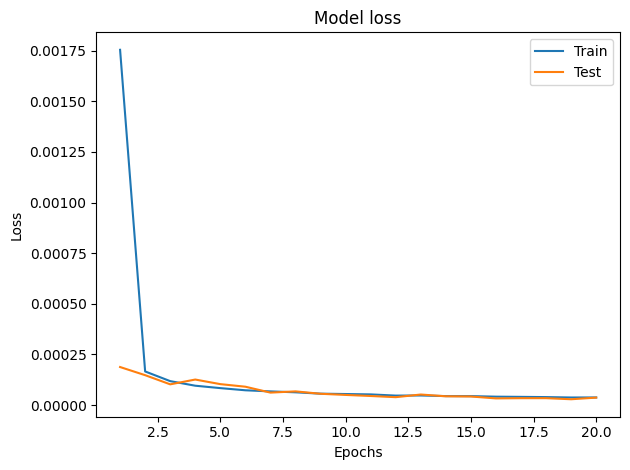

== Training Time ==
48.05 seconds

== Final loss ==
Train: 3.74776755052153e-05
Test: 3.66540189133957e-05

== Mean absolute error ==
Train: 0.0046666415777541805
Test: 0.004733391377975526

== R2 Score ==
Train: 0.9988644940131395
Test: 0.9988165131255772


In [65]:
displayLearningCurve(history=history_5R, 
                    epochs=epochs_5R)

print(f"== Training Time ==\n{training_time:.2f} seconds\n")
print(f"== Final loss ==\nTrain: {history_5R.history['loss'][-1]}\nTest: {history_5R.history['val_loss'][-1]}\n")
print(f"== Mean absolute error ==\nTrain: {mae_5R_train}\nTest: {mae_5R_test}\n")
print(f"== R2 Score ==\nTrain: {r2_5R_train}\nTest: {r2_5R_test}")

Once we are satisfied with our models, we can save them for future use:

In [ ]:
# if not os.path.exists('models'):
#     os.makedirs('models')

# model_2R.save(filepath=f'models/NN2_2R_p{int(percentage_2R*100)}_e{epochs_2R}.keras')
# model_3R.save(filepath=f'models/NN2_3R_p{int(percentage_3R*100)}_e{epochs_3R}.keras')
# model_5R.save(filepath=f'models/NN2_5R_p{int(percentage_5R*100)}_e{epochs_5R}.keras')